In [5]:
import bayes3d as b
import os
from bayes3d.viz.open3dviz import Open3DVisualizer
import jax.numpy as jnp
from jax.scipy.spatial.transform import Rotation as R
import open3d as o3d
import jax

GenJAX not installed. Importing bayes3d without genjax dependencies.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [6]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7052/static/


In [7]:
intrinsics = b.Intrinsics(
    height=200,
    width=200,
    fx=200.0, fy=200.0,
    cx=100.0, cy=100.0,
    near=0.001, far=6.0
)

In [8]:

visualizer = Open3DVisualizer(intrinsics)

[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x7fdc7d025010 (threading is enabled)
EGL(1.5)
OpenGL(4.1)


In [85]:
import os
model_dir = os.path.join(b.utils.get_assets_dir(), "ycb_video_models/models")
i = 4
mesh_path = os.path.join(model_dir, b.utils.ycb_loader.MODEL_NAMES[i], "textured.obj")
mesh  = o3d.io.read_triangle_model(mesh_path)

CPU times: user 1.56 s, sys: 0 ns, total: 1.56 s
Wall time: 1.33 s


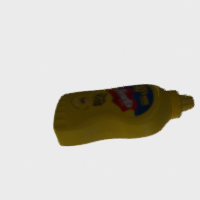

In [86]:
%%time
visualizer.render.scene.clear_geometry()
pose = b.distributions.gaussian_vmf(jax.random.PRNGKey(1000),b.transform_from_pos(jnp.array([0.0, 0.0, 0.3])), 0.01, 1.0)
mesh.meshes[0].mesh.transform(pose)
visualizer.render.scene.add_model(f"m", mesh)
mesh.meshes[0].mesh.transform(jnp.linalg.inv(pose))
rgbd = visualizer.capture_image(intrinsics, jnp.eye(4))
b.get_rgb_image(rgbd.rgb)

In [ ]:
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(5).rjust(6, '0') + ".ply")
mesh = b.utils.load_mesh(mesh_path)
vertices = jnp.array(mesh.vertices) / 1000.0

In [165]:
import diff_gaussian_rasterization as dgr
from diff_gaussian_rasterization import GaussianRasterizationSettings, GaussianRasterizer
import math
import torch
from diff_gaussian_rasterization import _C
import numpy as np
import functools
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def gaussian_raster_fwd(means3D, opacities, scales, rotations, colors_precomp, camera_pose, intrinsics):
    fovX = jnp.arctan(intrinsics.width / 2 / intrinsics.fx) * 2
    fovY = jnp.arctan(intrinsics.height / 2 / intrinsics.fy) * 2
    tan_fovx = math.tan(fovX)
    tan_fovy = math.tan(fovY)

    means3D = b.utils.jax_to_torch(means3D)
    N = means3D.shape[0]
    means2D = torch.ones((N, 3),requires_grad=True, device=device)
    
    opacities = b.utils.jax_to_torch(opacities)
    scales = b.utils.jax_to_torch(scales)
    rotations = b.utils.jax_to_torch(rotations)
    colors_precomp = b.utils.jax_to_torch(colors_precomp)

    view_matrix = torch.transpose(torch.tensor(np.array(b.inverse_pose(camera_pose))),0,1).cuda()

    def getProjectionMatrix(intrinsics):
        top = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
        bottom = -top
        right = intrinsics.near / intrinsics.fy * intrinsics.height / 2.0
        left = -right

        P = torch.zeros(4, 4)

        z_sign = 1.0

        P[0, 0] = 2.0 * intrinsics.near / (right - left)
        P[1, 1] = 2.0 * intrinsics.near / (top - bottom)
        P[0, 2] = (right + left) / (right - left)
        P[1, 2] = (top + bottom) / (top - bottom)
        P[2, 2] = z_sign * (intrinsics.far + intrinsics.near) / (intrinsics.far - intrinsics.near)
        P[2, 3] = -2.0 * (intrinsics.far * intrinsics.near) / (intrinsics.far - intrinsics.near)
        P[3, 2] = z_sign
        return torch.transpose(P, 0, 1)

    proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)

    raster_settings = GaussianRasterizationSettings(
        image_height=int(intrinsics.height),
        image_width=int(intrinsics.width),
        tanfovx=tan_fovx,
        tanfovy=tan_fovy,
        bg=torch.tensor([0.0, 0.0, 0.0]).cuda(),
        scale_modifier=1.0,
        viewmatrix=view_matrix,
        projmatrix=view_matrix @ proj_matrix,
        sh_degree=1,
        campos=torch.zeros(3).cuda(),
        prefiltered=False,
        debug=None
    )
    cov3Ds_precomp = torch.Tensor([])
    sh = torch.Tensor([])
    # (arg0: torch.Tensor, arg1: torch.Tensor, arg2: torch.Tensor, arg3: torch.Tensor, arg4: torch.Tensor, arg5: torch.Tensor, arg6: float, arg7: torch.Tensor, arg8: torch.Tensor, arg9: torch.Tensor, arg10: float, arg11: float, arg12: int, arg13: int, arg14: torch.Tensor, arg15: int, arg16: torch.Tensor, arg17: bool, arg18: bool)
    args = (
        raster_settings.bg, 
        means3D,
        colors_precomp,
        opacities,
        scales,
        rotations,
        raster_settings.scale_modifier,
        cov3Ds_precomp,
        raster_settings.viewmatrix,
        raster_settings.projmatrix,
        raster_settings.tanfovx,
        raster_settings.tanfovy,
        raster_settings.image_height,
        raster_settings.image_width,
        sh,
        raster_settings.sh_degree,
        raster_settings.campos,
        raster_settings.prefiltered,
        raster_settings.debug
    )

    num_rendered, color, radii, geomBuffer, binningBuffer, imgBuffer = _C.rasterize_gaussians(*args)
    return b.utils.torch_to_jax(color), (num_rendered,)
# num_rendered, colors_precomp, means3D, scales, rotations, cov3Ds_precomp, radii, sh, geomBuffer, binningBuffer, imgBuffer, raster_settings)

def gaussian_raster_bwd(saved_tensors, grad_out_color):
    # (num_rendered, colors_precomp, means3D, scales, rotations, cov3Ds_precomp, radii, sh, geomBuffer, binningBuffer, imgBuffer, raster_settings) = saved_tensors
    return None, None, None
    # Restructure args as C++ method expects them
    args = (raster_settings.bg,
            means3D, 
            radii, 
            colors_precomp, 
            scales, 
            rotations, 
            raster_settings.scale_modifier, 
            cov3Ds_precomp, 
            raster_settings.viewmatrix, 
            raster_settings.projmatrix, 
            raster_settings.tanfovx, 
            raster_settings.tanfovy, 
            b.utils.jax_to_torch(grad_out_color), 
            sh, 
            raster_settings.sh_degree, 
            raster_settings.campos,
            geomBuffer,
            num_rendered,
            binningBuffer,
            imgBuffer,
            raster_settings.debug)
    grad_means2D, grad_colors_precomp, grad_opacities, grad_means3D, grad_cov3Ds_precomp, grad_sh, grad_scales, grad_rotations = _C.rasterize_gaussians_backward(*args)
    return (b.utils.torch_to_jax(grad_means3D),
        b.utils.torch_to_jax(grad_opacities),
        b.utils.torch_to_jax(grad_scales),
        b.utils.torch_to_jax(grad_rotations),
        b.utils.torch_to_jax(grad_colors_precomp),None, None)

    # grads = (
    #     grad_means3D,
    #     grad_means2D,
    #     grad_sh,
    #     grad_colors_precomp,
    #     grad_opacities,
    #     grad_scales,
    #     grad_rotations,
    #     grad_cov3Ds_precomp,
    #     None,
    # )
@functools.partial(jax.custom_vjp, nondiff_argnums=(5,6,))
def gaussian_raster(means3D, opacities, scales, rotations, colors_precomp, camera_pose, intrinsics):
    return gaussian_raster_fwd(means3D, opacities, scales, rotations, colors_precomp, camera_pose, intrinsics)[0]

gaussian_raster.defvjp(gaussian_raster_fwd , gaussian_raster_bwd)



In [166]:
gt_color = jnp.transpose(rgbd.rgb, (2,0,1))[:3,...]

/var/tmp/ipykernel_4069085/3876057701.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)


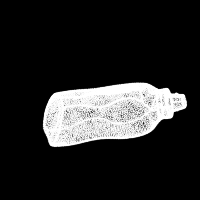

In [167]:
# quat = jax.random.uniform(jax.random.PRNGKey(31), (4,))
# transform = b.transform_from_rot_and_pos(b.quaternion_to_rotation_matrix(quat), jnp.array([0.0, 0.0, 0.5]))
means3D = b.apply_transform_jit(vertices, pose)
opacities = jnp.ones((means3D.shape[0],1), dtype=jnp.float32) * 10.0
scales = jnp.ones((means3D.shape[0],3), dtype=jnp.float32) * -10.0
rotations = jnp.ones((means3D.shape[0],4), dtype=jnp.float32)
colors_precomp = jnp.ones((means3D.shape[0],3), dtype=jnp.float32) * 255.0
camera_pose = jnp.eye(4)

def render(means3D, opacities, scales, rotations, colors_precomp, camera_pose, intrinsics):
    color = gaussian_raster(means3D, jax.nn.sigmoid(opacities), jnp.exp(scales), rotations, colors_precomp, camera_pose, intrinsics)
    return color        
def loss(means3D, opacities, scales, rotations, colors_precomp, camera_pose, intrinsics):
    color = gaussian_raster(means3D, opacities, scales, rotations, colors_precomp, camera_pose, intrinsics)
    return jnp.mean(jnp.abs(color - gt_color))
grad = jax.grad(loss, argnums=(0,1,2,))
color = render(means3D, opacities, scales, rotations, colors_precomp, camera_pose, intrinsics)
b.get_rgb_image(jnp.transpose(color, (1,2,0)))

In [164]:
grad(means3D, opacities, scales, rotations, colors_precomp, camera_pose, intrinsics)

/var/tmp/ipykernel_4069085/4281463300.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)


TypeError: gaussian_raster_bwd() takes 2 positional arguments but 4 were given

In [92]:
rgbd.rgb

Array([[[236., 235., 235., 255.],
        [236., 235., 236., 255.],
        [236., 235., 236., 255.],
        ...,
        [235., 235., 235., 255.],
        [236., 235., 236., 255.],
        [235., 235., 235., 255.]],

       [[235., 235., 235., 255.],
        [236., 235., 236., 255.],
        [235., 234., 234., 255.],
        ...,
        [236., 235., 235., 255.],
        [235., 234., 234., 255.],
        [236., 236., 236., 255.]],

       [[236., 236., 236., 255.],
        [236., 235., 236., 255.],
        [236., 235., 235., 255.],
        ...,
        [235., 234., 235., 255.],
        [235., 235., 235., 255.],
        [236., 235., 236., 255.]],

       ...,

       [[235., 235., 235., 255.],
        [236., 235., 235., 255.],
        [235., 235., 235., 255.],
        ...,
        [236., 236., 236., 255.],
        [235., 235., 235., 255.],
        [235., 235., 235., 255.]],

       [[236., 236., 236., 255.],
        [236., 236., 236., 255.],
        [236., 235., 235., 255.],
        .

In [81]:
%%time
color = gaussian_raster_fwd_jax(means3D, opacities, scales, rotations, colors_precomp, camera_pose, intrinsics)

CPU times: user 6.83 ms, sys: 0 ns, total: 6.83 ms
Wall time: 3.81 ms


/var/tmp/ipykernel_4069085/1958031017.py:45: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  proj_matrix = torch.tensor(getProjectionMatrix(intrinsics), device=device)


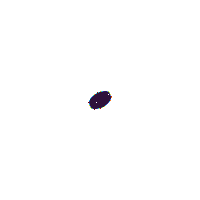

In [59]:
b.get_depth_image(color[0,...])

In [3]:
from diff_gaussian_rasterization._C import rasterize_gaussians

In [4]:
import diff_gaussian_rasterization
diff_gaussian_rasterization

<module 'diff_gaussian_rasterization' from '/opt/conda/envs/bayes3d/lib/python3.9/site-packages/diff_gaussian_rasterization/__init__.py'>

In [25]:
import nvdiffrast

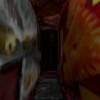

In [18]:
b.show_cloud("1",jnp.array(mesh.meshes[0].mesh.vertices))

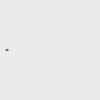